In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

# 1. GETTING DATA

Dataset includes:

* `x` : training data (all are normal samples)
* `tx` : test data samples (some normal, some abnormal)
* `ty` : tells you which are normal and which are not.
  * our autoencoder would reconstruct every sample with
ty=0 very well, and make mistakes when ty=1

In [2]:
# This code allows us to upload data from local drive
#from google.colab import files
#uploaded = files.upload()

Saving cardio.npz to cardio.npz


In [3]:
data = np.load('../data/cardio.npz')

In [6]:
X_train = data['x']
X_test = data['tx']
y_test= data['ty']

In [7]:
X_train

array([[ 1.69798491, -0.91998844, -0.20364049, ...,  1.67981029,
        -0.69058975, -0.49329397],
       [ 0.85144861, -0.91998844, -0.20364049, ...,  0.57633422,
        -0.62378908, -0.49329397],
       [-2.11142843, -0.18061463, -0.20364049, ..., -1.56165067,
        -0.59038875, -2.12660547],
       ...,
       [ 1.27471676, -0.91998844, -0.20364049, ...,  0.85220324,
        -0.62378908,  1.14001753],
       [ 1.27471676,  1.71403076, -0.04677629, ...,  1.26600677,
        -0.49018775,  1.14001753],
       [ 0.5339975 ,  1.17365699, -0.18424532, ...,  0.99013775,
         1.1464286 ,  1.14001753]])

In [72]:
X_train.shape

(1479, 21)

In [74]:
X_test.shape

(352, 21)

In [75]:
X_train.min()

-3.0048923462960526

In [76]:
X_train.max()

14.025335380634532

# 2. Feature scaling
- Using MinMaxScaler() in Scikit-learn to scale data

In [77]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train.copy())
X_test_scaled = scaler.transform(X_test.copy())

# 3. Create Autoencoder Model

In [78]:
# Create a model by subclassing Model class in tensorflow
class Autoencoder(Model):
  """
  An autoencoder with Encoder and decoder blocks
  
  Arguments:
    input_dim -- number of NN units at layer 0 (input)
         
  Returns: 
    autoencoder -- autoencoder Model
  """

  def __init__(self, input_dim):
    super().__init__()
    # encoder block
    self.encoder = Sequential([
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(8, activation='relu')
    ])
    # Decoder block
    self.decoder = Sequential([
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(input_dim, activation='sigmoid')
    ])

  def call(self, inputs):
    encode = self.encoder(inputs)
    decode = self.decoder(encode)
    return decode

In [79]:
# Create autoencoder model
autoencoder = Autoencoder(input_dim=X_train_scaled.shape[1])

# Loss and optimizer definition
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='msle',  #  Computes the mean squared logarithmic error between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 100
BATCH_SIZE = 256

# Fit the autoencoder
history = autoencoder.fit(x=X_train_scaled, 
                          y=X_train_scaled,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test_scaled, X_test_scaled),
                          shuffle=True)

Epoch 1/100
6/6 [==============================] - 1s 38ms/step - loss: 0.0702 - mse: 0.1151 - val_loss: 0.0765 - val_mse: 0.1293
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0654 - mse: 0.1063 - val_loss: 0.0703 - val_mse: 0.1184
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0570 - mse: 0.0915 - val_loss: 0.0599 - val_mse: 0.1014
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0447 - mse: 0.0715 - val_loss: 0.0473 - val_mse: 0.0834
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0327 - mse: 0.0537 - val_loss: 0.0394 - val_mse: 0.0751
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0265 - mse: 0.0459 - val_loss: 0.0376 - val_mse: 0.0737
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0237 - mse: 0.0421 - val_loss: 0.0361 - val_mse: 0.0707
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0216 - mse: 0.0386 - va

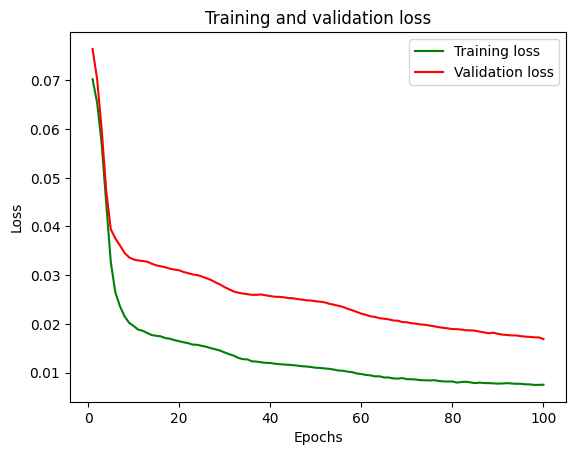

In [80]:
# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4. Finding a threshold

Figuring out a threshold which will be used to determine whether a prediction is normal or abnormal

?? Finding more methods to determine a threshold

In [81]:
def get_threshold(model, X_train):
  """
  Determine a threshold for anomalies
  
  Arguments:
    model -- trained model
    X_train -- input data which was used to train the model
         
  Returns: 
    threshold -- any prediction value bigger than threshold is anomalies
  """
  # getting predictions (recontructions) of the input data
  preds = model.predict(X_train)
  # calculate the difference between predictions and input data
  pred_errors = tf.keras.losses.msle(preds, X_train)
  # Calculate threshold for anomalies
  threshold = np.mean(pred_errors.numpy()) + np.std(pred_errors.numpy()) 
  return threshold


# 5. Classifying predictions into classes:

* 0: normal sample
* 1: anomaly


In [82]:
def get_predictions(model, X_test, threshold):
  """
  Get all predictions of samples
  
  Arguments:
    model -- trained model
    X_test -- samples, which should be predicted by the trained model
    threshold -- value to determine a prediction is anomaly or not
         
  Returns: 
    y_preds -- predicted labels of each sample (0: normal, 1: abnormal)
  """
  pred = model.predict(X_test)
  pred_errors = tf.keras.losses.msle(pred, X_test)
  y_preds = [0 if i < threshold else 1 for i in pred_errors]
  return y_preds



# 6. Autoencoder Anomaly Detection Performance

In [83]:
threshold = get_threshold(autoencoder, X_train_scaled)
print(f"Thrshold: {threshold}")

# get predictions of X_test_scaled
y_preds = get_predictions(autoencoder, X_test_scaled, threshold)

# Check the prediction performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))

from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_preds)
print(f"AUC: {auc_score}")

47/47 [==============================] - 0s 914us/step
Thrshold: 0.009893303120785669
11/11 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       176
           1       0.85      0.85      0.85       176

    accuracy                           0.85       352
   macro avg       0.85      0.85      0.85       352
weighted avg       0.85      0.85      0.85       352

AUC: 0.8494318181818182


In [84]:
# the above code block can be write in a function
def performance(model, X_train, X_test):
  threshold = get_threshold(model, X_train)
  print(f"Threshold: {threshold}")

  # get predictions of X_test_scaled
  y_preds = get_predictions(model, X_test, threshold)

  # Check the prediction performance
  print(classification_report(y_test, y_preds))
  auc_score = roc_auc_score(y_test, y_preds)
  print(f"AUC: {auc_score}")

# 7. Tuning hyperparameters to get better models

In [85]:
# Create autoencoder model
autoencoder_2 = Autoencoder(input_dim=X_train_scaled.shape[1])

# Loss and optimizer definition
autoencoder_2.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='msle',  #  Computes the mean squared logarithmic error between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 20
BATCH_SIZE = 128

# Fit the autoencoder
history_2 = autoencoder_2.fit(x=X_train_scaled, 
                          y=X_train_scaled,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test_scaled, X_test_scaled),
                          shuffle=True)

Epoch 1/20
12/12 [==============================] - 2s 22ms/step - loss: 0.0705 - mse: 0.1157 - val_loss: 0.0755 - val_mse: 0.1276
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 0.0614 - mse: 0.0992 - val_loss: 0.0595 - val_mse: 0.1015
Epoch 3/20
12/12 [==============================] - 0s 7ms/step - loss: 0.0402 - mse: 0.0651 - val_loss: 0.0414 - val_mse: 0.0792
Epoch 4/20
12/12 [==============================] - 0s 9ms/step - loss: 0.0258 - mse: 0.0449 - val_loss: 0.0362 - val_mse: 0.0698
Epoch 5/20
12/12 [==============================] - 0s 7ms/step - loss: 0.0217 - mse: 0.0385 - val_loss: 0.0348 - val_mse: 0.0677
Epoch 6/20
12/12 [==============================] - 0s 8ms/step - loss: 0.0193 - mse: 0.0348 - val_loss: 0.0327 - val_mse: 0.0648
Epoch 7/20
12/12 [==============================] - 0s 8ms/step - loss: 0.0181 - mse: 0.0331 - val_loss: 0.0319 - val_mse: 0.0631
Epoch 8/20
12/12 [==============================] - 0s 7ms/step - loss: 0.0173 - mse: 0.0

In [86]:
performance(autoencoder_2, X_train_scaled, X_test_scaled)

47/47 [==============================] - 0s 879us/step
Threshold: 0.016654403516558874
11/11 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       176
           1       0.84      0.94      0.89       176

    accuracy                           0.88       352
   macro avg       0.89      0.88      0.88       352
weighted avg       0.89      0.88      0.88       352

AUC: 0.8835227272727273


In [87]:
# Create autoencoder model
autoencoder_3 = Autoencoder(input_dim=X_train_scaled.shape[1])

# Loss and optimizer definition
autoencoder_3.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='msle',  #  Computes the mean squared logarithmic error between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 10
BATCH_SIZE = 256

# Fit the autoencoder
history_3 = autoencoder_3.fit(x=X_train_scaled, 
                          y=X_train_scaled,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test_scaled, X_test_scaled),
                          shuffle=True)

Epoch 1/10
6/6 [==============================] - 1s 38ms/step - loss: 0.0729 - mse: 0.1201 - val_loss: 0.0793 - val_mse: 0.1345
Epoch 2/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0705 - mse: 0.1156 - val_loss: 0.0781 - val_mse: 0.1323
Epoch 3/10
6/6 [==============================] - 0s 12ms/step - loss: 0.0690 - mse: 0.1127 - val_loss: 0.0764 - val_mse: 0.1292
Epoch 4/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0666 - mse: 0.1082 - val_loss: 0.0734 - val_mse: 0.1238
Epoch 5/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0622 - mse: 0.1002 - val_loss: 0.0678 - val_mse: 0.1142
Epoch 6/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0544 - mse: 0.0865 - val_loss: 0.0583 - val_mse: 0.0990
Epoch 7/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0421 - mse: 0.0669 - val_loss: 0.0459 - val_mse: 0.0818
Epoch 8/10
6/6 [==============================] - 0s 9ms/step - loss: 0.0306 - mse: 0.0503 - val_loss:

In [88]:
performance(autoencoder_3, X_train_scaled, X_test_scaled)

47/47 [==============================] - 0s 2ms/step
Threshold: 0.029546466532260597
11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       176
           1       0.84      0.89      0.87       176

    accuracy                           0.86       352
   macro avg       0.86      0.86      0.86       352
weighted avg       0.86      0.86      0.86       352

AUC: 0.8636363636363636


In [91]:
# Create autoencoder model
autoencoder_4 = Autoencoder(input_dim=X_train_scaled.shape[1])

# Loss and optimizer definition
autoencoder_4.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='msle',  #  Computes the mean squared logarithmic error between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 20
BATCH_SIZE = 64

# Fit the autoencoder
history_4 = autoencoder_4.fit(x=X_train_scaled, 
                          y=X_train_scaled,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test_scaled, X_test_scaled),
                          shuffle=True)

Epoch 1/20
24/24 [==============================] - 2s 9ms/step - loss: 0.0695 - mse: 0.1136 - val_loss: 0.0720 - val_mse: 0.1214
Epoch 2/20
24/24 [==============================] - 0s 3ms/step - loss: 0.0438 - mse: 0.0710 - val_loss: 0.0393 - val_mse: 0.0754
Epoch 3/20
24/24 [==============================] - 0s 3ms/step - loss: 0.0216 - mse: 0.0383 - val_loss: 0.0340 - val_mse: 0.0663
Epoch 4/20
24/24 [==============================] - 0s 4ms/step - loss: 0.0180 - mse: 0.0328 - val_loss: 0.0327 - val_mse: 0.0646
Epoch 5/20
24/24 [==============================] - 0s 4ms/step - loss: 0.0171 - mse: 0.0315 - val_loss: 0.0316 - val_mse: 0.0623
Epoch 6/20
24/24 [==============================] - 0s 3ms/step - loss: 0.0161 - mse: 0.0299 - val_loss: 0.0308 - val_mse: 0.0612
Epoch 7/20
24/24 [==============================] - 0s 3ms/step - loss: 0.0157 - mse: 0.0292 - val_loss: 0.0305 - val_mse: 0.0607
Epoch 8/20
24/24 [==============================] - 0s 3ms/step - loss: 0.0153 - mse: 0.02

In [92]:
performance(autoencoder_4, X_train_scaled, X_test_scaled)

47/47 [==============================] - 0s 862us/step
Threshold: 0.015113364702069584
11/11 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       176
           1       0.86      0.91      0.88       176

    accuracy                           0.88       352
   macro avg       0.88      0.88      0.88       352
weighted avg       0.88      0.88      0.88       352

AUC: 0.8806818181818182


In [93]:
# Create autoencoder model
autoencoder_5 = Autoencoder(input_dim=X_train_scaled.shape[1])

# Loss and optimizer definition
autoencoder_5.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='msle',  #  Computes the mean squared logarithmic error between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 50
BATCH_SIZE = 128

# Fit the autoencoder
history_5 = autoencoder_5.fit(x=X_train_scaled, 
                          y=X_train_scaled,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test_scaled, X_test_scaled),
                          shuffle=True)

Epoch 1/50
12/12 [==============================] - 2s 18ms/step - loss: 0.0709 - mse: 0.1164 - val_loss: 0.0777 - val_mse: 0.1318
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0651 - mse: 0.1059 - val_loss: 0.0682 - val_mse: 0.1159
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0475 - mse: 0.0770 - val_loss: 0.0493 - val_mse: 0.0900
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0304 - mse: 0.0517 - val_loss: 0.0371 - val_mse: 0.0713
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0228 - mse: 0.0404 - val_loss: 0.0338 - val_mse: 0.0654
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0199 - mse: 0.0355 - val_loss: 0.0337 - val_mse: 0.0658
Epoch 7/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0188 - mse: 0.0340 - val_loss: 0.0328 - val_mse: 0.0646
Epoch 8/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0181 - mse: 0.0

In [94]:
performance(autoencoder_5, X_train_scaled, X_test_scaled)

47/47 [==============================] - 0s 2ms/step
Threshold: 0.01051551705104101
11/11 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       176
           1       0.86      0.86      0.86       176

    accuracy                           0.86       352
   macro avg       0.86      0.86      0.86       352
weighted avg       0.86      0.86      0.86       352

AUC: 0.8607954545454546


# 7. Save and load the best model

The best model is `autoencoder_2` with AUC = 88.35

In [97]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
autoencoder_2.save('saved_model/my_model')

In [98]:
# Reload the saved model
new_model = tf.keras.models.load_model('saved_model/my_model')

In [99]:
performance(new_model, X_train_scaled, X_test_scaled)

47/47 [==============================] - 0s 1ms/step
Threshold: 0.016654403516558874
11/11 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       176
           1       0.84      0.94      0.89       176

    accuracy                           0.88       352
   macro avg       0.89      0.88      0.88       352
weighted avg       0.89      0.88      0.88       352

AUC: 0.8835227272727273


# 8. Test new architecture of model

In [100]:
# Create a model by subclassing Model class in tensorflow
class AutoencoderV2(Model):
  """
  An autoencoder with Encoder and decoder blocks
  
  Arguments:
    input_dim -- number of NN units at layer 0 (input)
         
  Returns: 
    autoencoder -- autoencoder Model
  """

  def __init__(self, input_dim):
    super().__init__()
    # encoder block
    self.encoder = Sequential([
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(4, activation='relu')
    ])
    # Decoder block
    self.decoder = Sequential([
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(input_dim, activation='sigmoid')
    ])

  def call(self, inputs):
    encode = self.encoder(inputs)
    decode = self.decoder(encode)
    return decode

In [101]:
# Create autoencoder model
auto_v2 = AutoencoderV2(input_dim=X_train_scaled.shape[1])

# Loss and optimizer definition
auto_v2.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='msle',  #  Computes the mean squared logarithmic error between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 20
BATCH_SIZE = 128

# Fit the autoencoder
history_v2 = auto_v2.fit(x=X_train_scaled, 
                          y=X_train_scaled,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test_scaled, X_test_scaled),
                          shuffle=True)

Epoch 1/20
12/12 [==============================] - 2s 17ms/step - loss: 0.0712 - mse: 0.1169 - val_loss: 0.0785 - val_mse: 0.1330
Epoch 2/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0689 - mse: 0.1126 - val_loss: 0.0757 - val_mse: 0.1280
Epoch 3/20
12/12 [==============================] - 0s 5ms/step - loss: 0.0647 - mse: 0.1049 - val_loss: 0.0702 - val_mse: 0.1183
Epoch 4/20
12/12 [==============================] - 0s 4ms/step - loss: 0.0562 - mse: 0.0898 - val_loss: 0.0594 - val_mse: 0.1006
Epoch 5/20
12/12 [==============================] - 0s 5ms/step - loss: 0.0422 - mse: 0.0671 - val_loss: 0.0442 - val_mse: 0.0786
Epoch 6/20
12/12 [==============================] - 0s 4ms/step - loss: 0.0294 - mse: 0.0489 - val_loss: 0.0358 - val_mse: 0.0695
Epoch 7/20
12/12 [==============================] - 0s 5ms/step - loss: 0.0234 - mse: 0.0407 - val_loss: 0.0326 - val_mse: 0.0641
Epoch 8/20
12/12 [==============================] - 0s 6ms/step - loss: 0.0208 - mse: 0.0

In [102]:
performance(auto_v2, X_train_scaled, X_test_scaled)

47/47 [==============================] - 0s 1ms/step
Threshold: 0.02151638411884621
11/11 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       176
           1       0.82      0.94      0.88       176

    accuracy                           0.87       352
   macro avg       0.88      0.87      0.87       352
weighted avg       0.88      0.87      0.87       352

AUC: 0.8693181818181819


In [103]:
# Create autoencoder model
auto_v3 = AutoencoderV2(input_dim=X_train_scaled.shape[1])

# Loss and optimizer definition
auto_v3.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='msle',  #  Computes the mean squared logarithmic error between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 50
BATCH_SIZE = 128

# Fit the autoencoder
history_v3 = auto_v3.fit(x=X_train_scaled, 
                          y=X_train_scaled,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test_scaled, X_test_scaled),
                          shuffle=True)

Epoch 1/50
12/12 [==============================] - 2s 17ms/step - loss: 0.0713 - mse: 0.1172 - val_loss: 0.0785 - val_mse: 0.1329
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0688 - mse: 0.1124 - val_loss: 0.0748 - val_mse: 0.1263
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0633 - mse: 0.1021 - val_loss: 0.0668 - val_mse: 0.1122
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0516 - mse: 0.0821 - val_loss: 0.0520 - val_mse: 0.0888
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0363 - mse: 0.0586 - val_loss: 0.0383 - val_mse: 0.0711
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0270 - mse: 0.0457 - val_loss: 0.0337 - val_mse: 0.0659
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0231 - mse: 0.0403 - val_loss: 0.0324 - val_mse: 0.0636
Epoch 8/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0212 - mse: 0.0

In [104]:
performance(auto_v3, X_train_scaled, X_test_scaled)

47/47 [==============================] - 0s 2ms/step
Threshold: 0.016718616889630153
11/11 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       176
           1       0.86      0.95      0.90       176

    accuracy                           0.89       352
   macro avg       0.90      0.89      0.89       352
weighted avg       0.90      0.89      0.89       352

AUC: 0.8948863636363635


In [109]:
# Save the model auto_v3 with AUC=0.89
auto_v3.save('saved_model/auto_v3')

In [118]:
# Reload model auto_v3
reload_auto_v3 = tf.keras.models.load_model('saved_model/auto_v3')

In [119]:
performance(reload_auto_v3, X_train_scaled, X_test_scaled)

47/47 [==============================] - 0s 1ms/step
Threshold: 0.016718616889630153
11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       176
           1       0.86      0.95      0.90       176

    accuracy                           0.89       352
   macro avg       0.90      0.89      0.89       352
weighted avg       0.90      0.89      0.89       352

AUC: 0.8948863636363635
